In [1]:
# import data
import numpy as np
import pandas as pd
trius = np.load('trius.npy')
labels = np.load('labels.npy')

In [2]:
# Feartue Selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, SelectPercentile, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve# 模型度量
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA, NMF
from sklearn.base import clone

seed = 2019
np.random.seed(seed)
X = trius
y = labels

X = MinMaxScaler().fit_transform(X)

selector = VarianceThreshold(0.03)
selector.fit(X)
X = selector.transform(X)
print(X.shape)

selector = SelectKBest(chi2, k=2048)
X = selector.fit_transform(X, y)
print(X.shape)

etc = GradientBoostingClassifier().fit(X, y)
model = SelectFromModel(etc, prefit=True)
X = model.transform(X)
print(X.shape)

#X = PCA(n_components=128).fit_transform(X)
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

(252, 3772)
(252, 2048)
(252, 146)
(252, 146)
样本集大小： (252, 146) (252,)
训练集大小： (226, 146) (226,)
测试集大小： (26, 146) (26,)


In [3]:
from matplotlib import pyplot as plt
from mlens.visualization import corrmat, pca_plot, pca_comp_plot
from mlens.ensemble import SuperLearner


def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=10)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((64, 16), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=seed)
    rf = RandomForestClassifier(n_estimators=10, max_features=5, random_state=seed)
    ab = AdaBoostClassifier(random_state=seed)
    
    models = {'svm': svc, 'knn': knn, 'naive bayes': nb,
             'mlp': nn, 'random forest': rf, 'gbm': gb, 'logistic': lr,
             'adaboost': ab,}
    return models


def get_meta():
    meta_learner = GradientBoostingClassifier(
       n_estimators=1000,
       loss="exponential",
       max_features=4,
       max_depth=3,
       subsample=0.5,
       learning_rate=0.005, 
       random_state=seed
    )
    return meta_learner

def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(x_train, y_train)
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))


def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    cm = [plt.cm.rainbow(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()


def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        m.fit(x_train, y_train)
    print('done.')


def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P


def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]


def stacking(base_learners, meta_learner, X, y, generator):
    print('Fitting base learners...', end='')
    train_base_learners(base_learners, X, y)
    print('done.')
    
    print('Generating cross-validated predctions...')
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):
        fold_x_train, fold_y_train = X[train_idx, :], y[train_idx]
        fold_x_test, fold_y_test = X[test_idx, :], y[test_idx]
        fold_base_learners = {name: clone(model) for name, model in base_learners.items()}
        train_base_learners(fold_base_learners, fold_x_train, fold_y_train)
        fold_P_base = predict_base_learners(fold_base_learners, fold_x_test)
        cv_preds.append(fold_P_base)
        cv_y.append(fold_y_test)
        print('Fold %i done' %i)
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)
    
    print('Fitting meta learner...', end='')
    meta_learner.fit(cv_preds, cv_y)
    print('done')
    return base_learners, meta_learner


def cross_val_stacking(base_learners, meta_learner, X, y, generator):
    cv_scores = []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):
        fold_x_train, fold_y_train = X[train_idx, :], y[train_idx]
        fold_x_test, fold_y_test = X[test_idx, :], y[test_idx]
        cv_base_learners, cv_meta_learner = stacking(get_models(), clone(meta_learner), fold_x_train, fold_y_train, generator)
        _, p = ensemble_predict(cv_base_learners, cv_meta_learner, fold_x_test)
        acc = accuracy_score(fold_y_test, np.float32(p > 0.5))
        cv_scores.append(acc)
    return cv_scores

def get_ensemble():
    sl = SuperLearner(folds=10, random_state=seed, verbose=2, backend='multiprocessing')
    sl.add(list(get_models().values()), proba=True)
    sl.add_meta(get_meta(), proba=True)
    return sl

[MLENS] backend: threading
[MLENS] Found 11 residual cache(s):
        1 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_0wraav2g
        2 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_3c0o84i4
        3 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_hhco2aq3
        4 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_oyp251kf
        5 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_qv91by2i
        6 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_t_gxeol6
        7 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_u8wzk42f
        8 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_w2tv1c7g
        9 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_wby0l9od
        10 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache_z1i2jysl
        11 (4096): C:\Users\hasee007\AppData\Local\Temp\.mlens_tmp_cache__iycpf_4
        Total size: 45056
[MLENS] Removing..

In [4]:
sl = get_ensemble()

In [5]:
sl.fit(x_train, y_train)


Fitting 2 layers
Processing layer-1             done | 00:00:10
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:11


SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=5957, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=2048, sample_size=20, scorer=None, shuffle=False,
       verbose=2)

In [6]:
p_sl = sl.predict_proba(x_test)


Predicting 2 layers
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:07


In [7]:
print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(y_test, p_sl[:, 1]))
print("\nSuper Learner ACC score: %.3f" % accuracy_score(y_test, np.float32(p_sl[:, 1] >= 0.5)))


Super Learner ROC-AUC score: 0.905

Super Learner ACC score: 0.808


In [8]:
idx = list(range(len(X)))
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
cv_scores = []
for i, (train_idx, test_idx) in enumerate(KFold(10).split(X)):
    fold_x_train, fold_y_train = X[train_idx, :], y[train_idx]
    fold_x_test, fold_y_test = X[test_idx, :], y[test_idx]
    sl = get_ensemble()
    sl.fit(fold_x_train, fold_y_train)
    fold_p = sl.predict_proba(fold_x_test)
    fold_y_pred = np.argmax(fold_p, axis=1)
    acc = accuracy_score(fold_y_test, fold_y_pred)
    recall = recall_score(fold_y_test, fold_y_pred)
    cm = confusion_matrix(fold_y_test, fold_y_pred)
    roc = roc_auc_score(fold_y_test, fold_p[:, 1])
    cv_scores.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})


Fitting 2 layers
Processing layer-1             done | 00:00:10
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:11

Predicting 2 layers
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:07

Fitting 2 layers
Processing layer-1             done | 00:00:10
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:11

Predicting 2 layers
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:08

Fitting 2 layers
Processing layer-1             done | 00:00:10
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:11

Predicting 2 layers
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:07

Fitting 2 layers
Processing layer-1 

In [9]:
acc = [i['acc'] for i in cv_scores]
recall = [i['recall'] for i in cv_scores]
roc = [i['roc_auc_score'] for i in cv_scores]

In [10]:
acc

[0.8076923076923077,
 0.9230769230769231,
 0.88,
 0.88,
 0.88,
 0.92,
 0.92,
 0.76,
 0.8,
 0.76]

In [11]:
recall

[0.7857142857142857,
 0.9473684210526315,
 0.9375,
 1.0,
 0.8421052631578947,
 0.9285714285714286,
 1.0,
 0.9333333333333333,
 0.8181818181818182,
 0.7058823529411765]

In [12]:
roc

[0.875,
 0.9548872180451129,
 0.8750000000000001,
 0.9807692307692308,
 0.9736842105263157,
 0.9935064935064934,
 1.0,
 0.9266666666666666,
 0.8701298701298701,
 0.8382352941176471]

In [13]:
P = pd.DataFrame(np.array([acc, recall, roc]).T, columns=['acc', 'recall', 'roc auc score'])

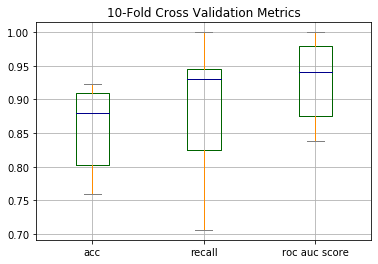

In [14]:
color = dict(boxes='DarkGreen',whiskers='DarkOrange',medians='DarkBlue',caps='Gray')
P.plot.box(grid=True, color=color, title='10-Fold Cross Validation Metrics')

In [15]:
print(np.mean(acc), np.std(acc)*2)
print(np.mean(recall), np.std(recall)*2)
print(np.mean(roc), np.std(roc)*2)

0.8530769230769231 0.1236697262204132
0.8898656902952569 0.18475855968514776
0.9287878983761336 0.11329587156769383
